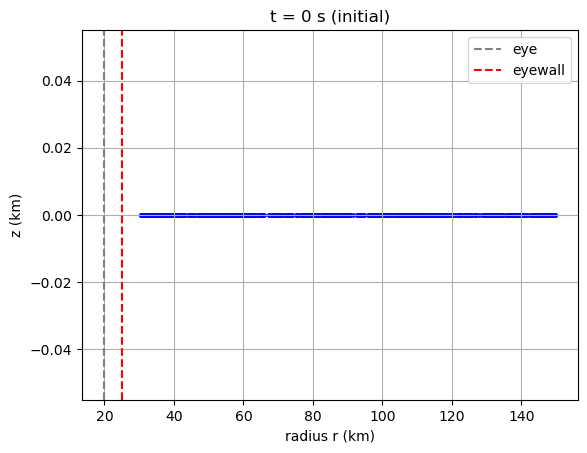

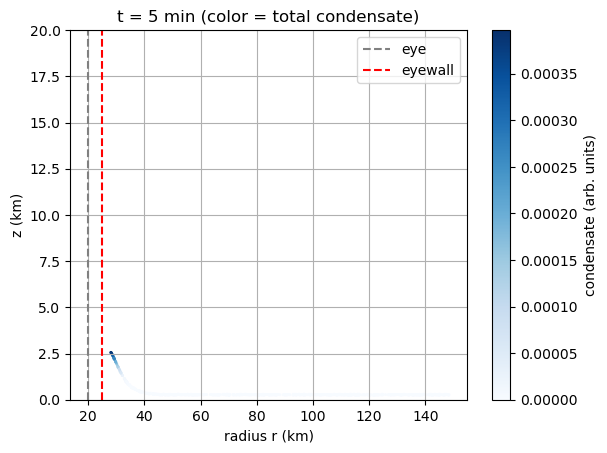

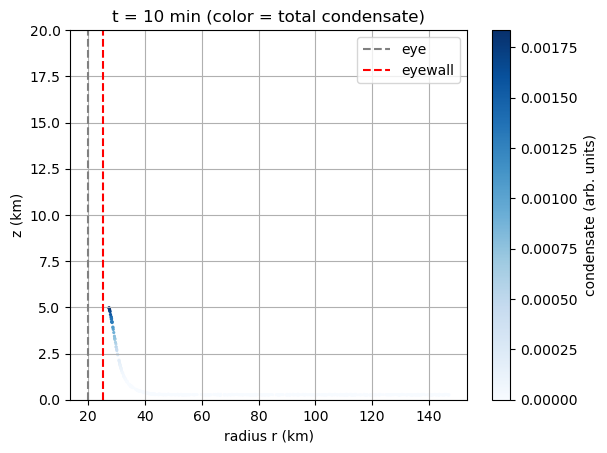

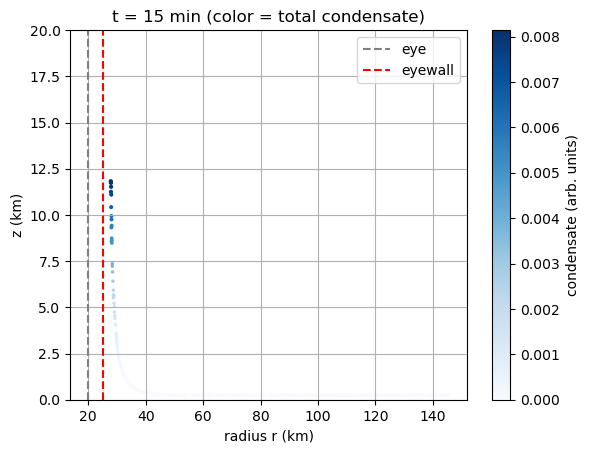

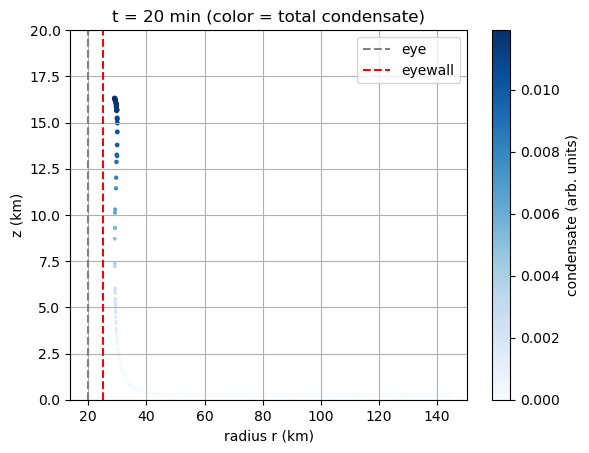

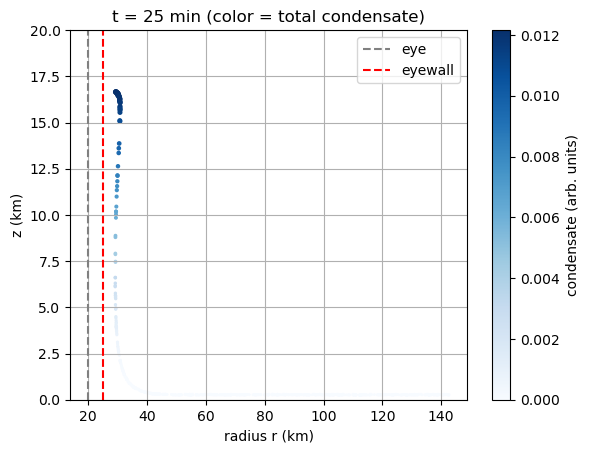

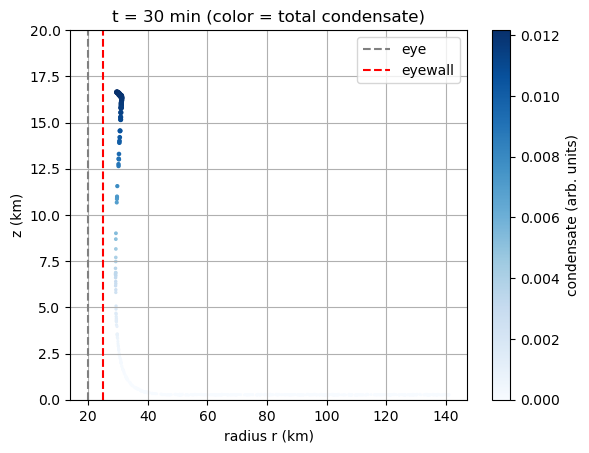

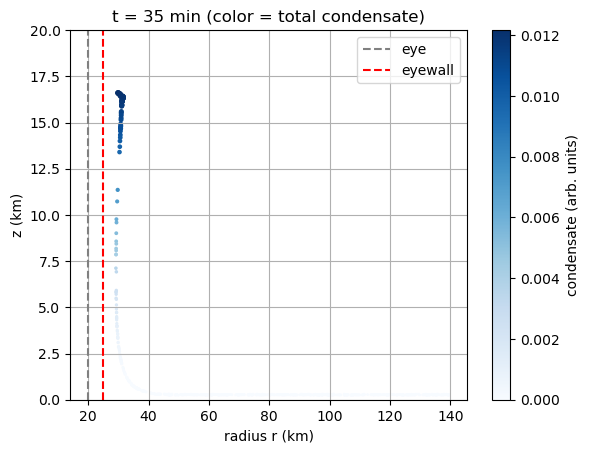

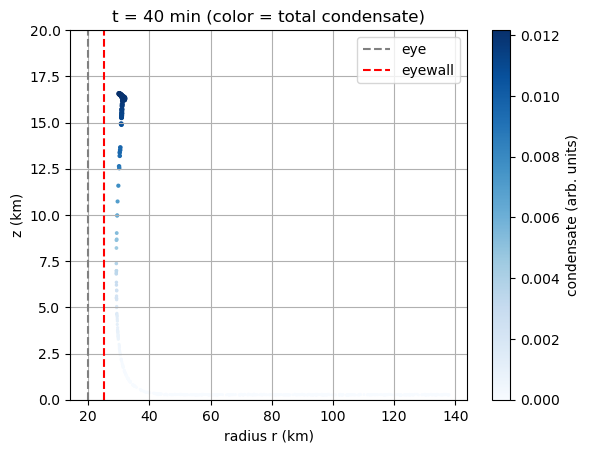

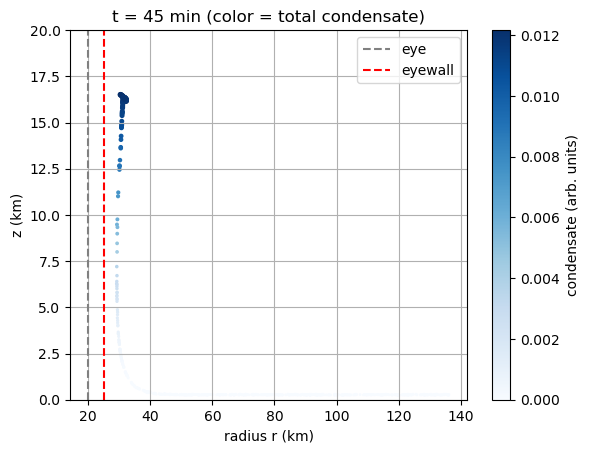

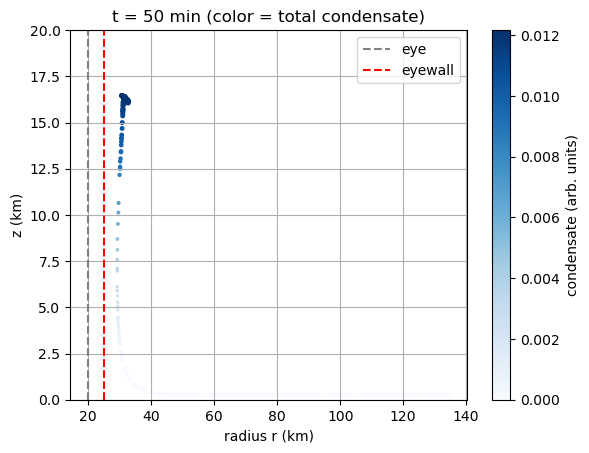

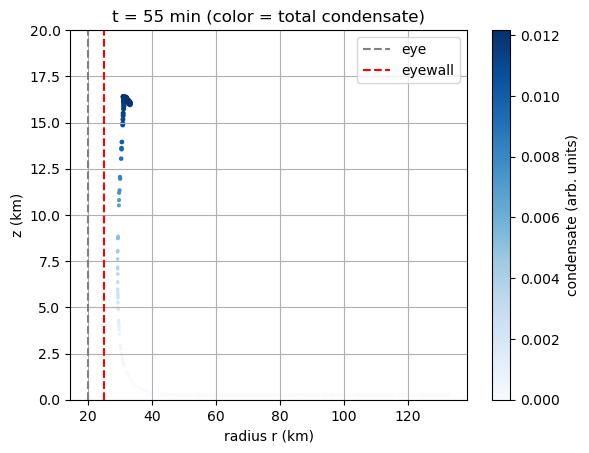

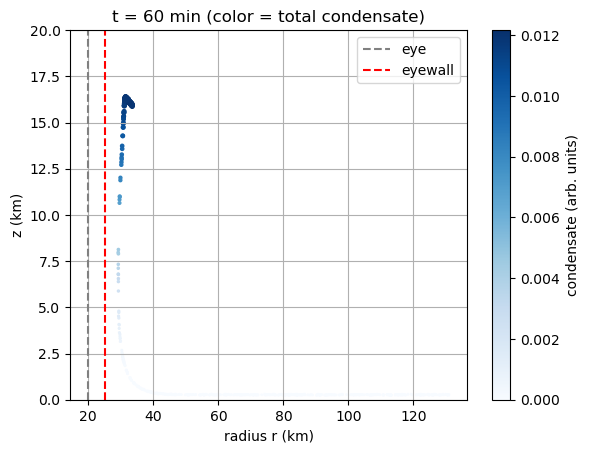

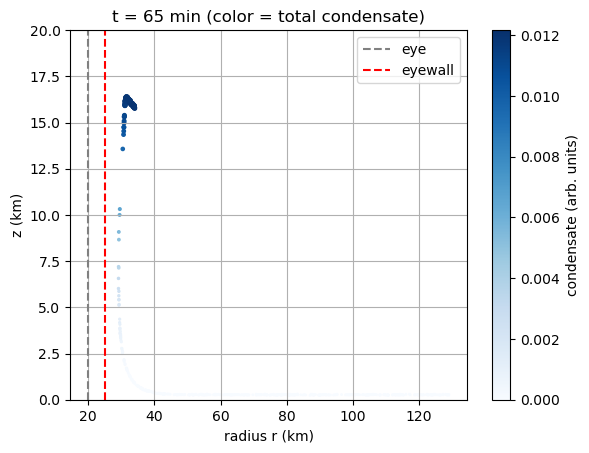

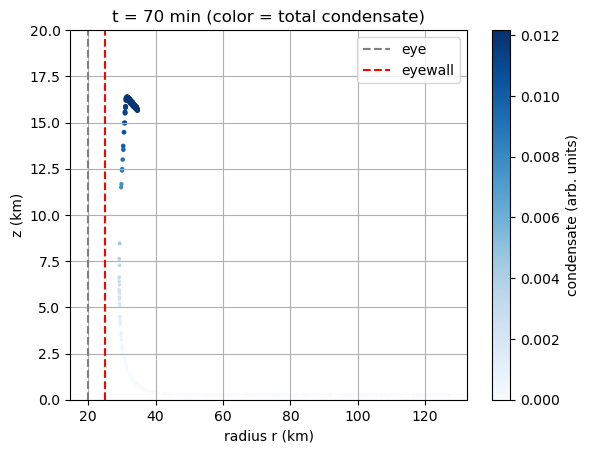

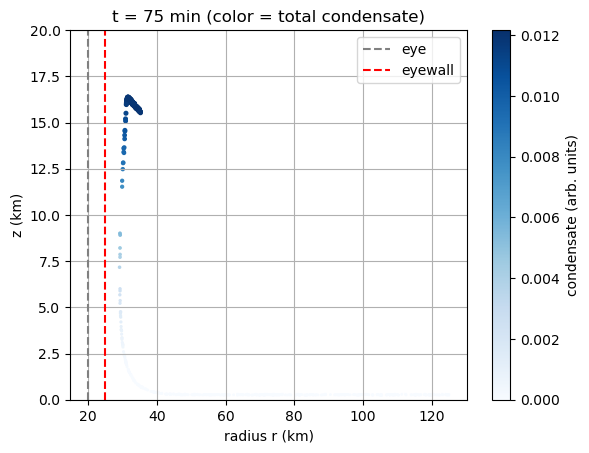

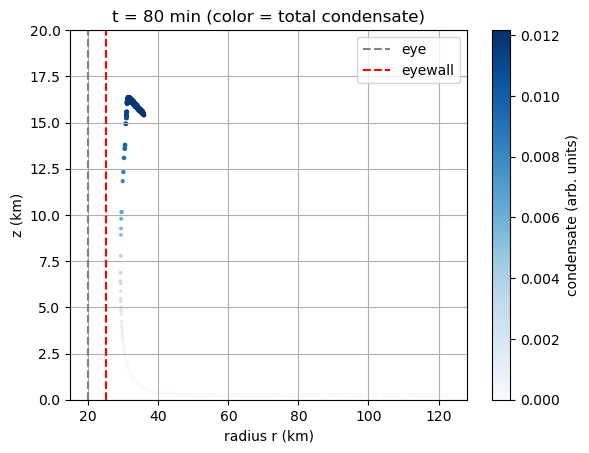

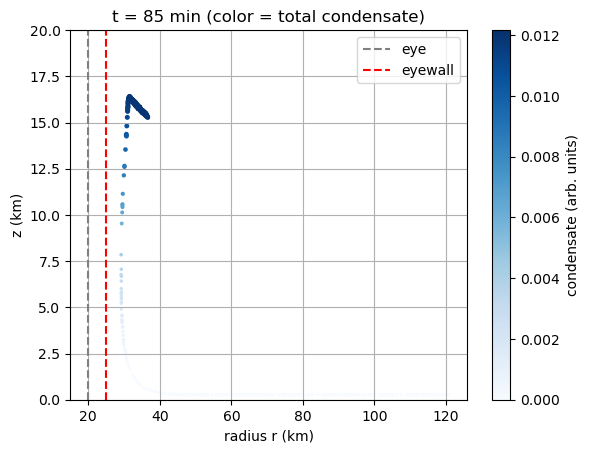

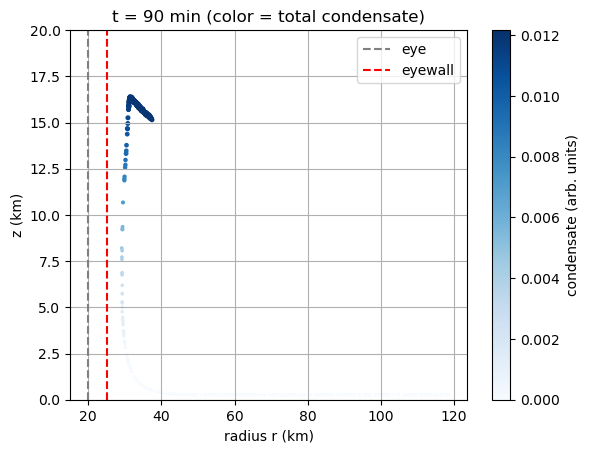

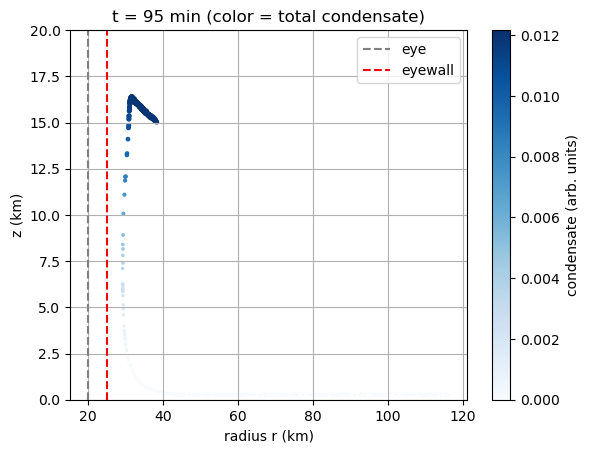

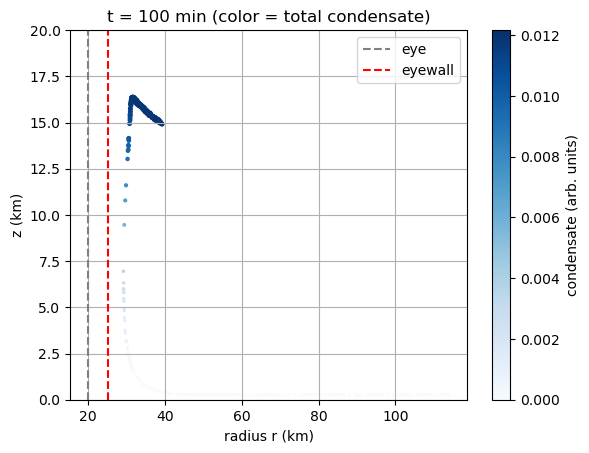

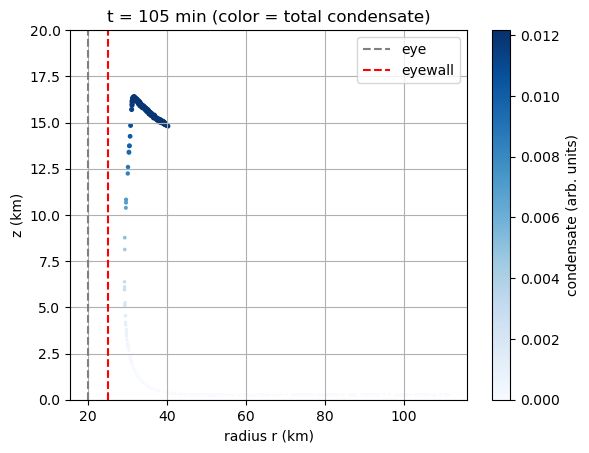

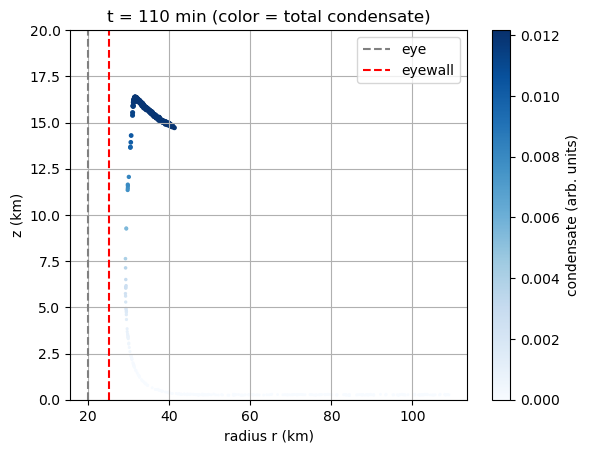

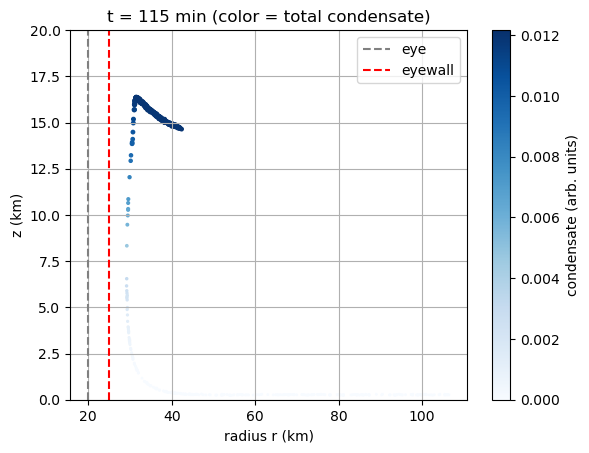

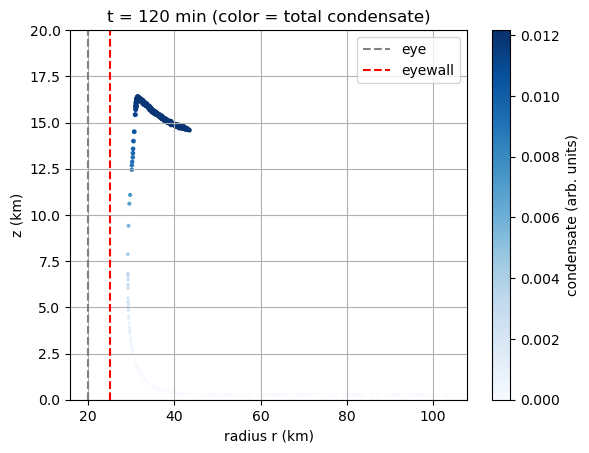

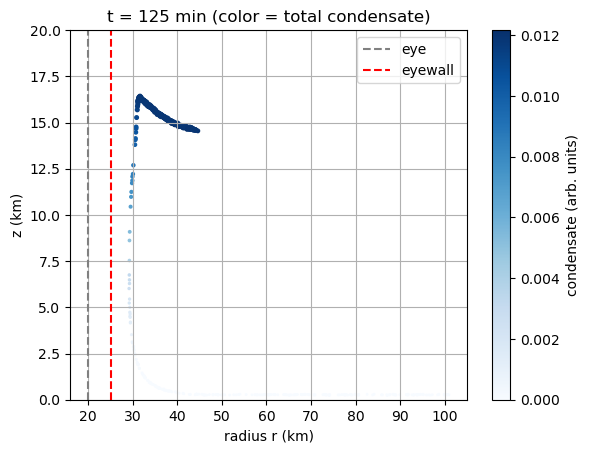

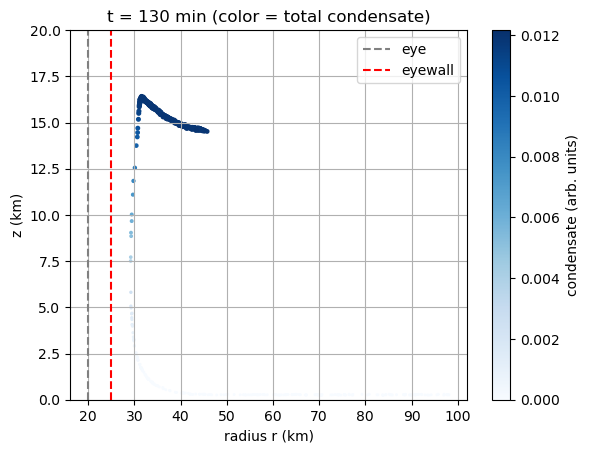

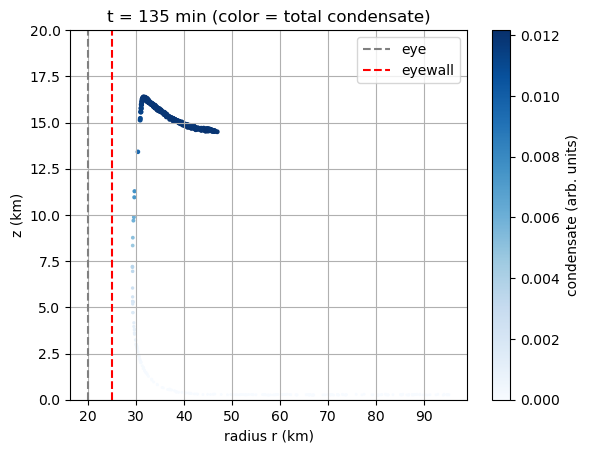

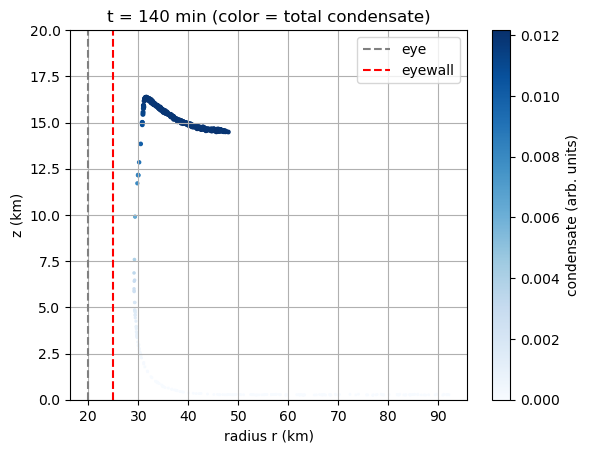

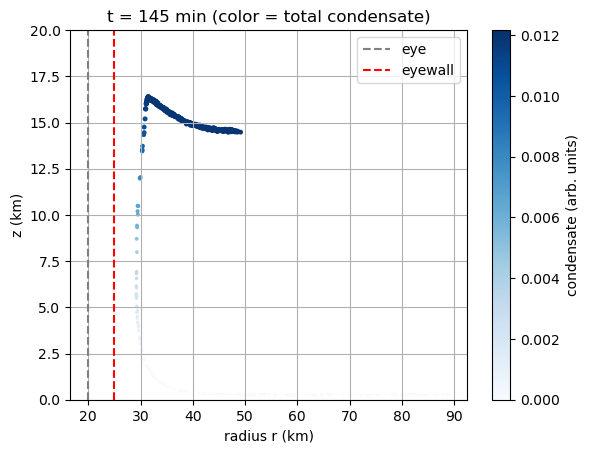

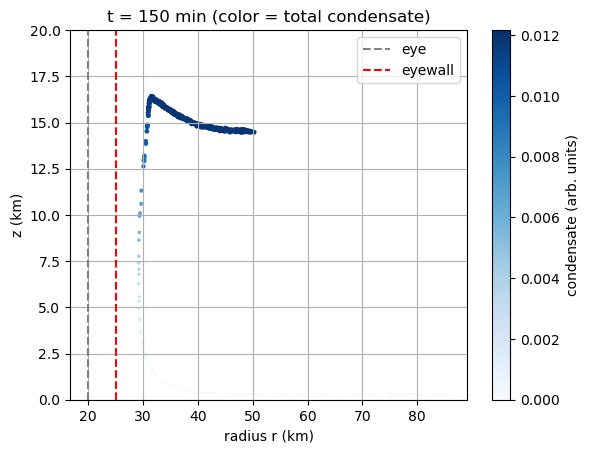

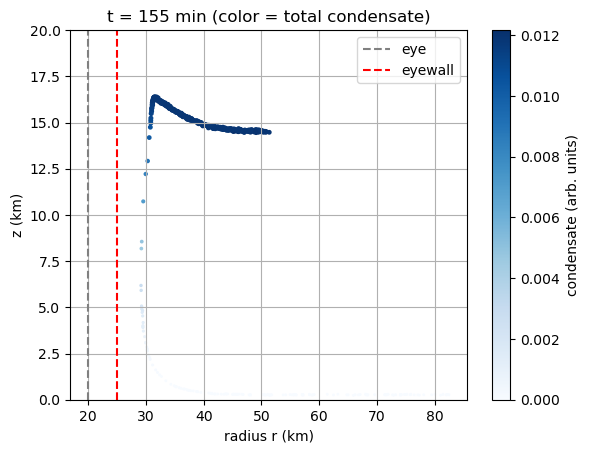

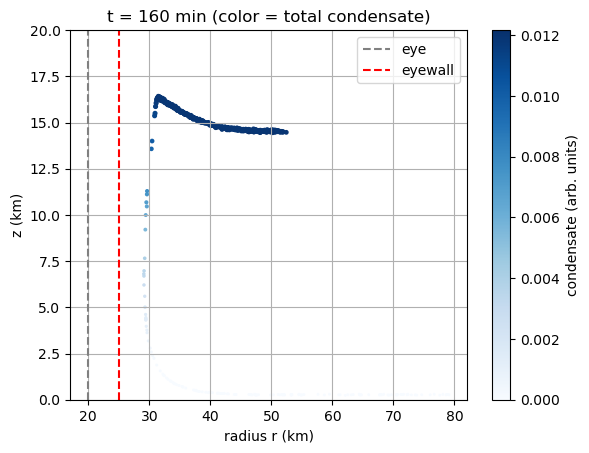

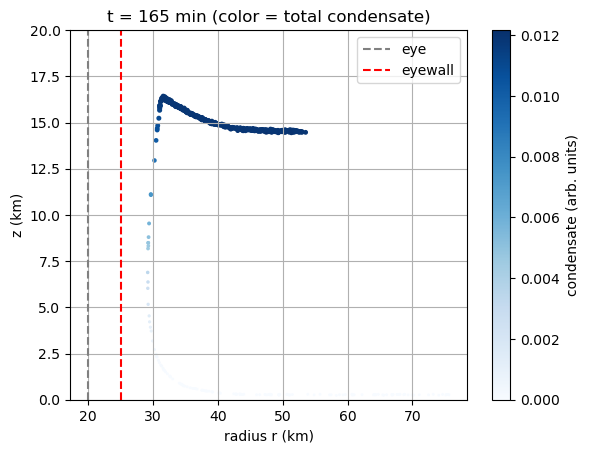

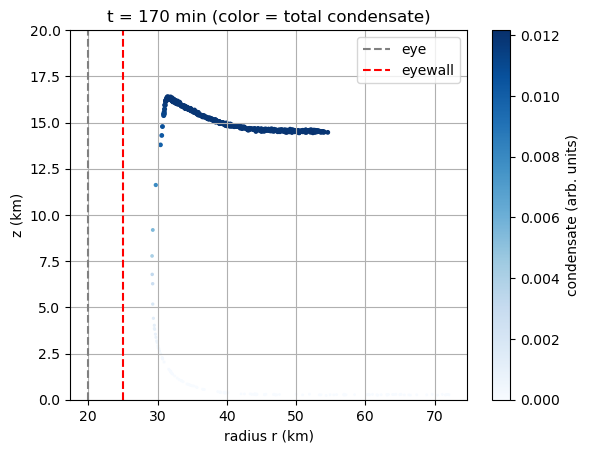

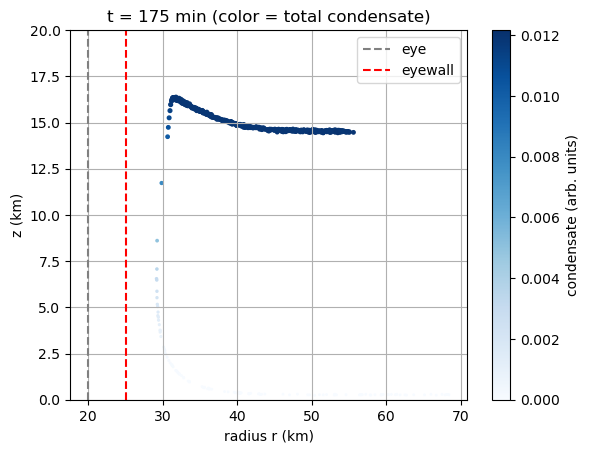

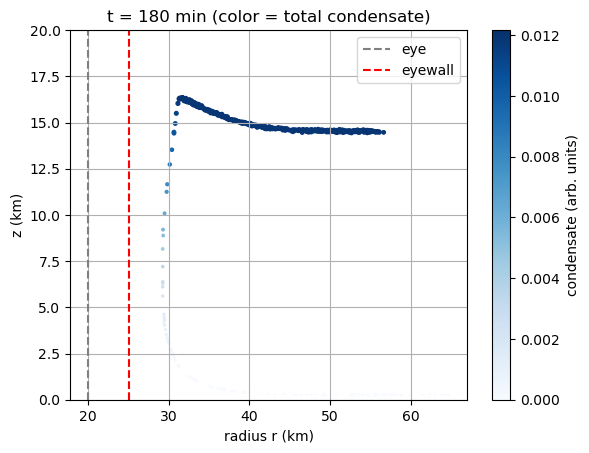

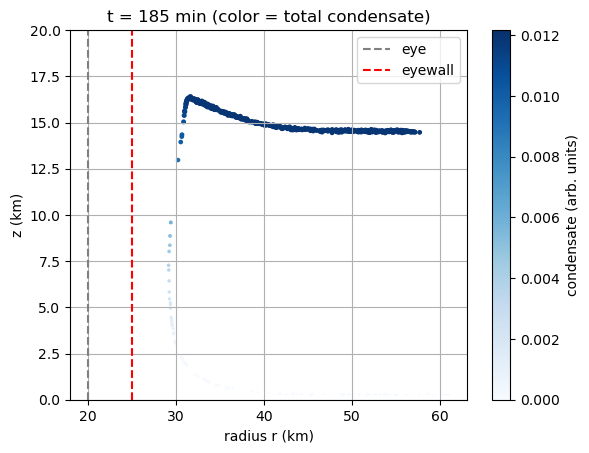

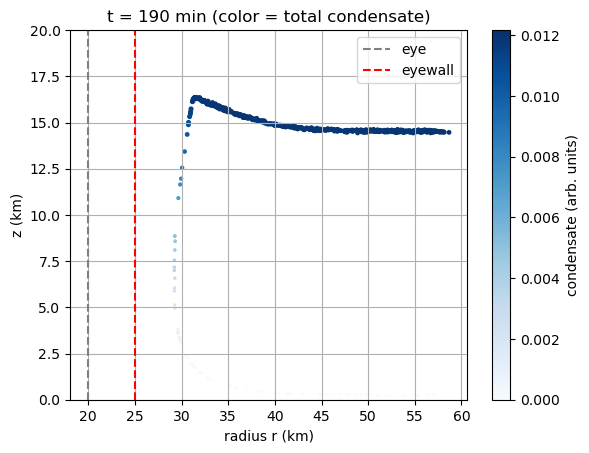

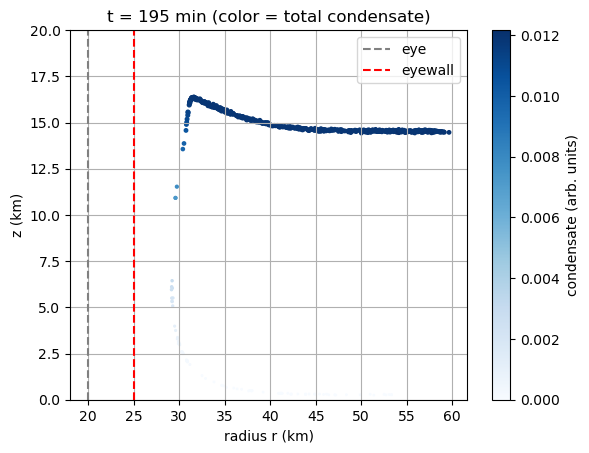

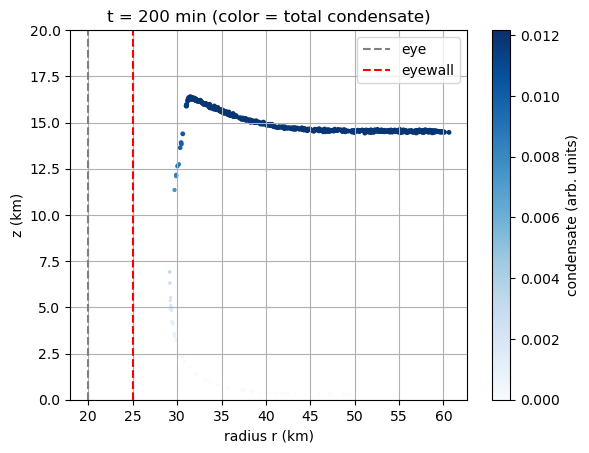

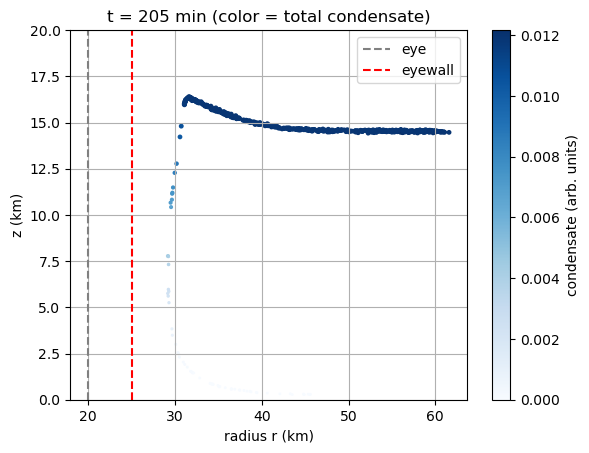

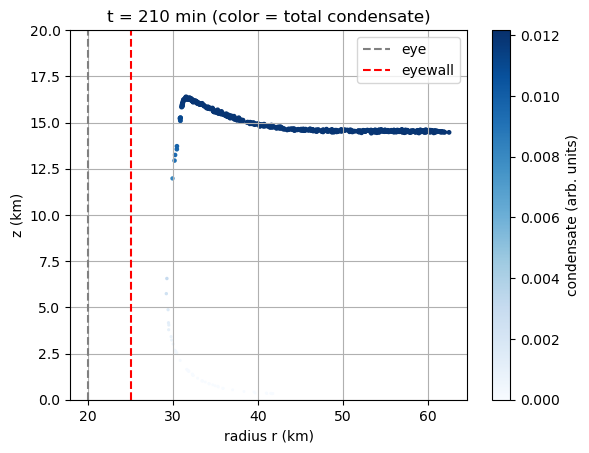

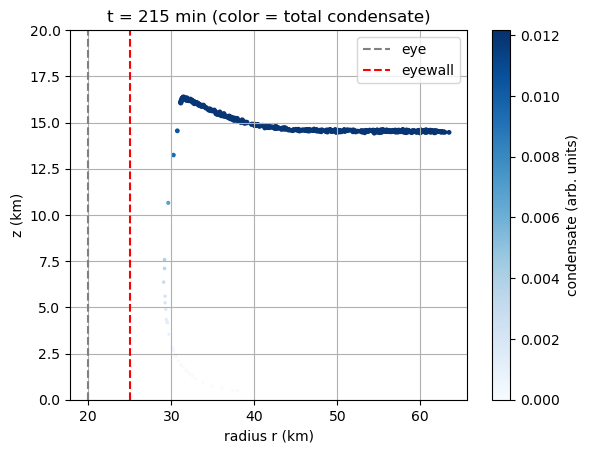

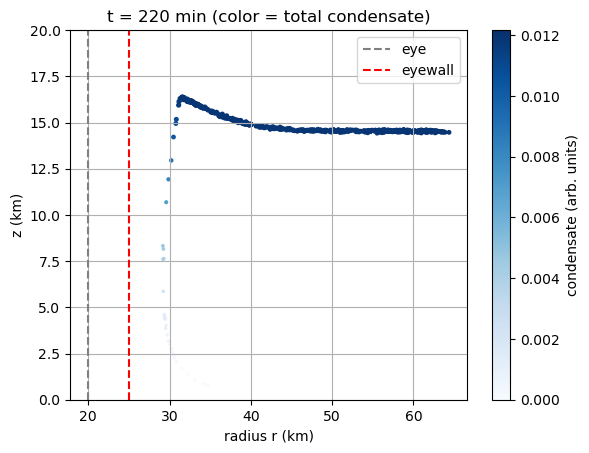

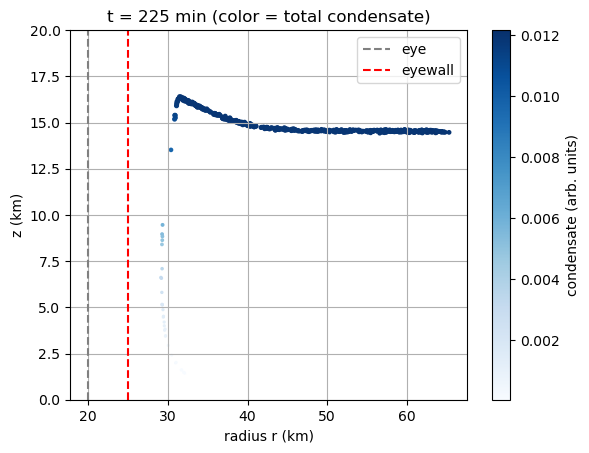

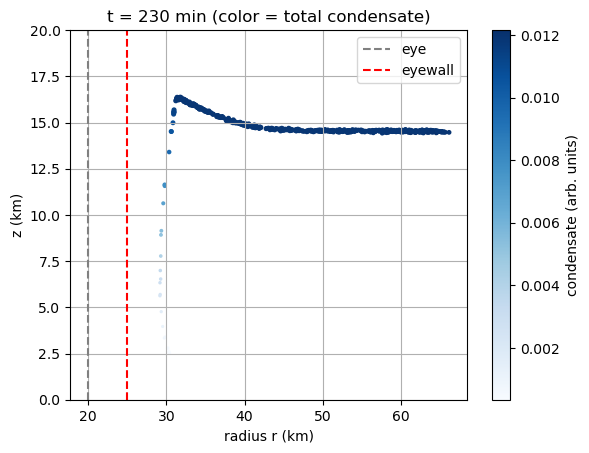

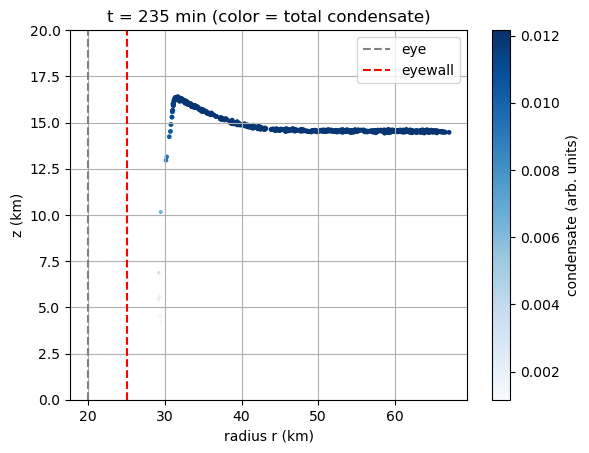

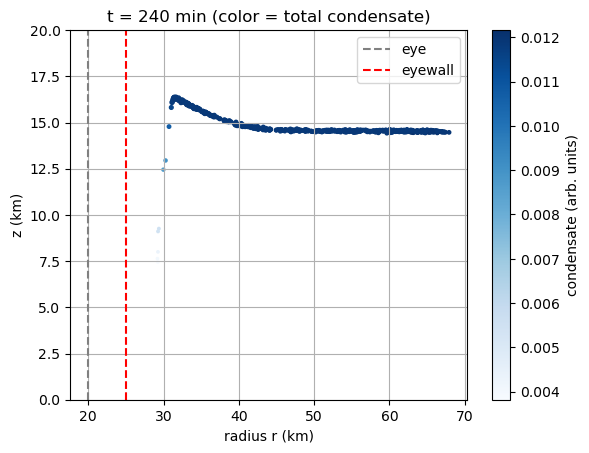

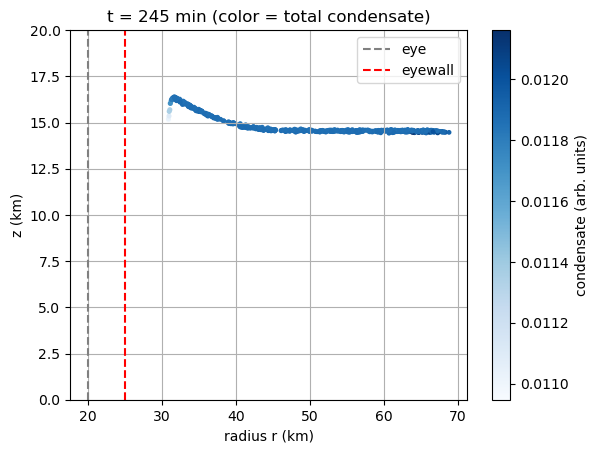

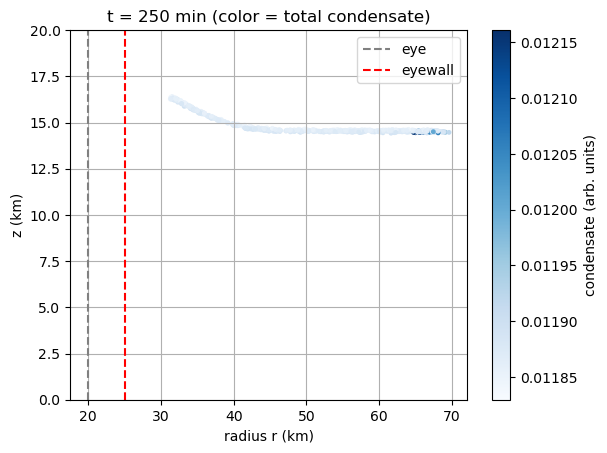

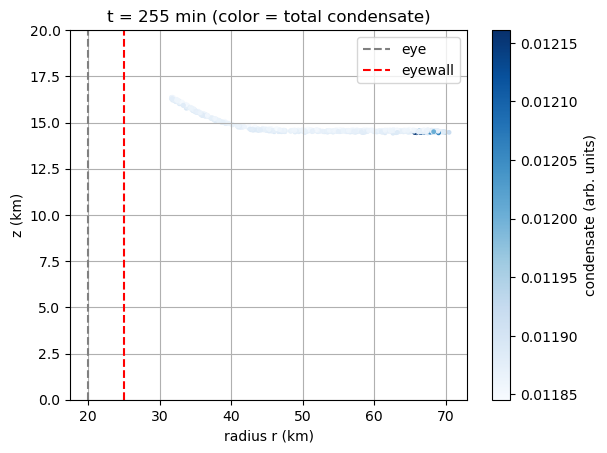

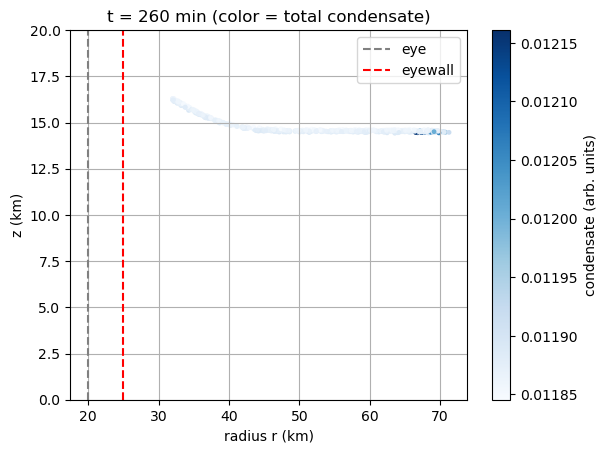

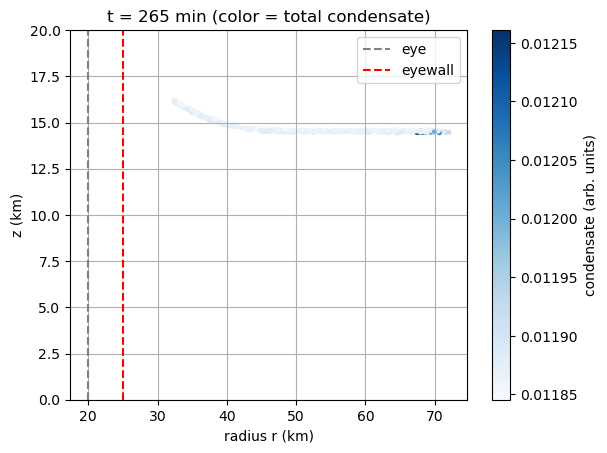

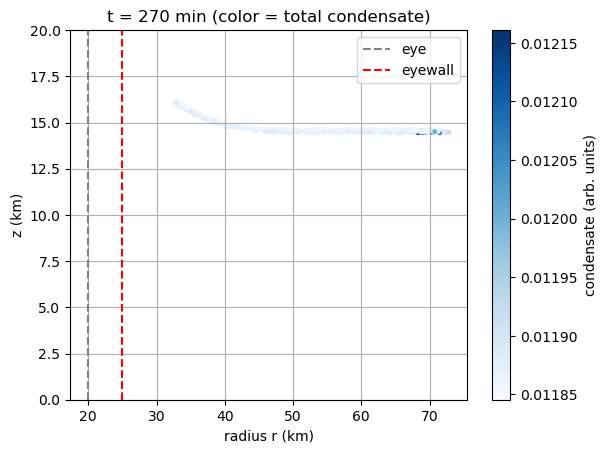

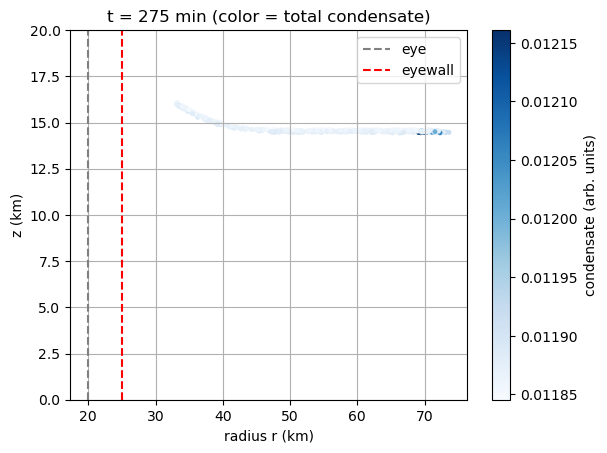

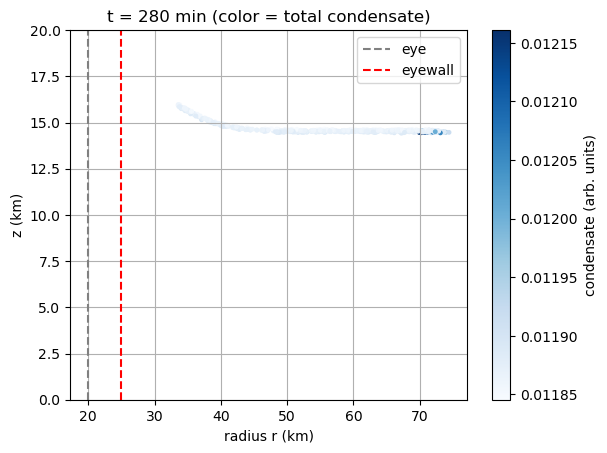

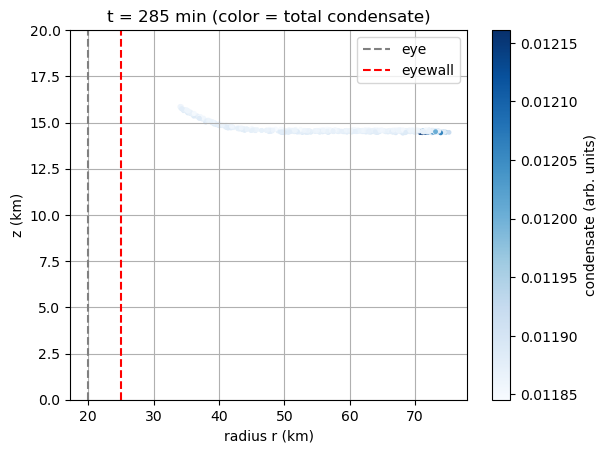

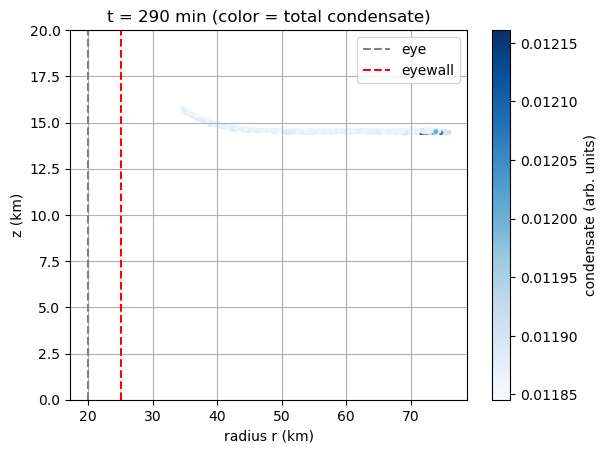

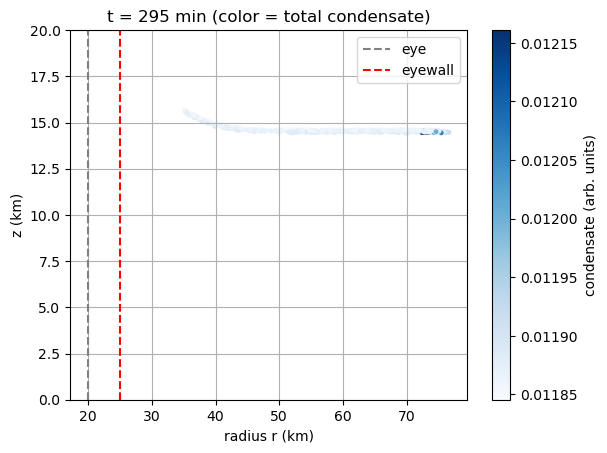

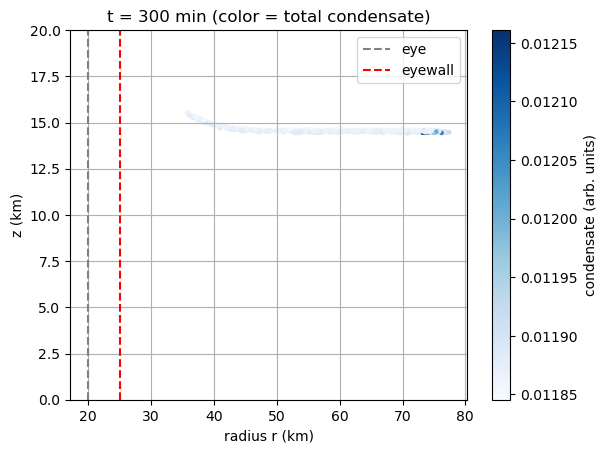

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------- CONSTANTS -----------------
g = 9.81
cp = 1005.0 # Specific heat o dry air J/kg*K
Rd = 287.0 # Specific gas constant of dry air J/kg*K
Rv = 461.0 # Specific gas constant of water vapor J/kg*K
L = 2.5e6 # Heat of vaporization of water J/kg
eps = 0.622
T0 = 273.15
p0 = 1e5
epsilon_drag = 0.05
mu_entrain = 1e-4
temperatures = []
pressures = []
qs = []
Z =[]
v_p_list = []
# ----------------- HURRICANE RADII (m) -----------------
r_eye = 20e3      # eye radius
r_ew  = 25e3      # eyewall radius
r_rb  = 150e3      # first rainband
r_max = 150e3     # outer domain

# ----------------- THERMODYNAMICS -----------------

def sat_mix_ratio(T, p):
    es = 1710 * np.exp((T - 288) / 16.5)  # Pa, Clausius-Clapeyron
    e = es * p / (p + 0.378 * es)
    return eps * e / (p - e)

'''def moist_lapse_rate(T, p):
    q_s = sat_mix_ratio(T, p)
    Gamma_d = g / cp
    num = 1.0 + L * q_s / (Rd * T)
    den = 1.0 + (L**2 * q_s * eps) / (cp * Rv * T**2)
    return Gamma_d * num / den   # K/m'''

def moist_lapse_rate(T, p):
    r = sat_mix_ratio(T,p)
    numerator = 1 + (L * r) / (Rd *T)
    denominator = cp + (L**2 * r) /(Rv * T**2)
    return g * numerator / denominator


def env_T(z):
    z = np.asarray(z)
    T = np.empty_like(z, dtype=float)
    mask = z < 7000.0
    T[mask] = 300.0 - g/cp* z[mask]
    T[~mask] = 216.65
    return T

def env_q(z): #specific humidity 
    return 0.15 * np.exp(-z / 8000)

def parcels_volume(initial_volume,initial_pressure,final_pressure):
    """Calculate the change in parcel volume based on pressure change using ideal gas law."""
    return initial_volume * (initial_pressure / final_pressure)

# ----------------- SECONDARY CIRCULATION -----------------

def inflow_radial_velocity(r, z, Vmax_in=15.0):
    """Boundary-layer inflow toward center outside eye."""
    fr = np.exp(-((r - 2.0*r_eye)/(0.7*r_max))**2)
    fr *= (r > r_eye)
    fz = np.exp(-z / 2000.0)      # mostly below 2 km
    return -Vmax_in * fr * fz     # negative = inward

def outflow_radial_velocity(r, z, Vmax_out=10.0):
    """Upper-level outflow above ~10 km."""
    fz = np.exp(-((z - 12000.0)/3000.0)**2)
    fr = np.exp(-(r/(0.6*r_max))**2)
    return Vmax_out * fr * fz     # positive = outward

def eyewall_updraft_forcing(r, z, W0=1.0, sigma_r=5e3):
    fr = np.exp((-0.5*((r - r_ew)/sigma_r)**2)/2)
    fz = np.exp(-z/1000)
    return W0 * (fr + fz)

'''def rainband_updraft_forcing(r, z, W0=2.0, sigma_r=10e3):
    fr = np.exp(-0.5*((r - r_rb)/sigma_r)**2)
    fz = np.exp(-z/8000.0)
    return W0 * fr * fz'''

def eye_subsidence_forcing(r, z, W0=1.0):
    fr = np.exp(-0.5*(r/(0.6*r_eye))**2)
    fz = np.exp(-((z - 6000.0)/4000.0)**2)
    return -W0 * (fr + fz)



def simulate_hurricane_parcels(
        Npar=600,
        t_max=18000.0,
        dt=1.0
    ):
    """
    Simple axisymmetric hurricane cross-section in (r,z) using Lagrangian parcels.
    r = radius from center, z = height.
    Eyewall at r_ew, weak eye subsidence at r<r_eye.
    """

    N = int(t_max / dt) + 1

    # --- initial parcels: low-level ring outside eyewall ---
    r = np.random.uniform(r_ew + 5e3, r_max, size=Npar)
    z = np.full(Npar, 0.0)
    w = np.full(Npar, 0.1)
    T_p = np.full(Npar, 302.0) + np.random.normal(0, 0.3, size=Npar)
    q_p = np.full(Npar, 0.018)
    condensate = np.zeros(Npar)   # total condensed water along trajectory

    # plot initial state (no condensation yet)
    plt.figure()
    plt.scatter(r/1000.0, z/1000.0, c='blue', s=6)
    plt.axvline(r_eye/1000.0, color='gray', ls='--', label='eye')
    plt.axvline(r_ew/1000.0,  color='r',   ls='--', label='eyewall')
    plt.xlabel('radius r (km)')
    plt.ylabel('z (km)')
    plt.title('t = 0 s (initial)')
    plt.legend()
    plt.grid(True)
    plt.show()

    for n in range(1, N):
        t = n * dt

        # environment
        p_env = p0 * np.exp(-z / 8000.0)
        p_p = p_env.copy()
        v_p = parcels_volume(1.0, p0,p_p)
        T_e = env_T(z)
        q_e = env_q(z)
        q_s = sat_mix_ratio(T_p, p_p)

        # buoyancy
        Tv_p = T_p * (1.0 + 0.608 * q_p)
        Tv_e = T_e * (1.0 + 0.608 * q_e)
        B = g * (Tv_p - Tv_e) / Tv_e

        # secondary circulation forcings
        w_forcing = (eyewall_updraft_forcing(r, z) +
                     eye_subsidence_forcing(r, z))
        u_r = inflow_radial_velocity(r, z) + outflow_radial_velocity(r, z)

        # thermodynamics & condensation
        saturated = q_p >= 0.99 * q_s
        dTdt = np.zeros_like(T_p)
        dqdt_cond = np.zeros_like(q_p)

        if np.any(saturated):
            Gamma_m = moist_lapse_rate(T_p[saturated], p_p[saturated])
            dTdt[saturated] = -Gamma_m * w[saturated]
            dq_excess = np.maximum(q_p[saturated] - q_s[saturated], 0.0)
            dqdt_cond[saturated] = -dq_excess * np.maximum(w[saturated], 0.0) / 8000.0
            # accumulate total condensate (proxy for rain produced)
            condensate[saturated] += -dqdt_cond[saturated] * dt

        dry = ~saturated
        dTdt[dry] = - (g / cp) * w[dry]

        cond_rate = -dqdt_cond

        # simple rain‑induced downdrafts (above 7 km where heavy condensation)
        thresh = 1e-6
        heavy = cond_rate > thresh
        Wd = 3.0
        downdraft = np.zeros_like(w)
        mask_dd = (z > 7000.0) & heavy
        downdraft[mask_dd] = -Wd * np.exp(-z[mask_dd] / 3000.0)

        # vertical momentum ###CHECK IN LITTERATURE 
        dwdt = B - epsilon_drag * w + w_forcing + downdraft
        w = np.clip(w + dwdt * dt, -15.0, 50.0)

        # radial and vertical position
        r = np.clip(r + u_r * dt, 0.0, r_max)
        z = np.maximum(z + w * dt, 0.0)

        # entrainment
        dqdt_entr = mu_entrain * (q_e - q_p) * np.abs(w) / np.maximum(z, 100.0)

        # update T and q
        T_p = T_p + dTdt * dt
        temperatures.append(T_p[0])
        q_p = q_p + (dqdt_cond + dqdt_entr) * dt
        pressures.append(p_env[0])
        qs.append(q_p[0])
        Z.append(z[0])
        v_p_list.append(v_p[0])

        # plot every 300 s (5 min) for evolution, colored by condensate
        if n % 300 == 0 or n == N - 1:
            plt.figure()
            sc = plt.scatter(r/1000.0, z/1000.0, c=condensate,
                             cmap='Blues', s = v_p)
            plt.axvline(r_eye/1000.0, color='gray', ls='--', label='eye')
            plt.axvline(r_ew/1000.0,  color='r',   ls='--', label='eyewall')
            plt.xlabel('radius r (km)')
            plt.ylabel('z (km)')
            plt.title(f't = {t/60:.0f} min (color = total condensate)')
            plt.legend()
            plt.grid(True)
            plt.colorbar(sc, label='condensate (arb. units)',)
            plt.ylim((0,20))
            plt.show()



simulate_hurricane_parcels()

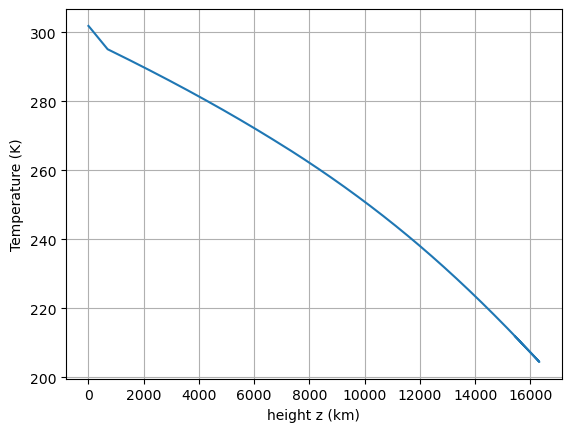

In [23]:
plt.figure()
plt.plot(Z, temperatures)
plt.xlabel('height z (km)')
plt.ylabel('Temperature (K)')
#plt.title(f'Temperature of an air parcel depending on height')
plt.grid(True)
plt.show()


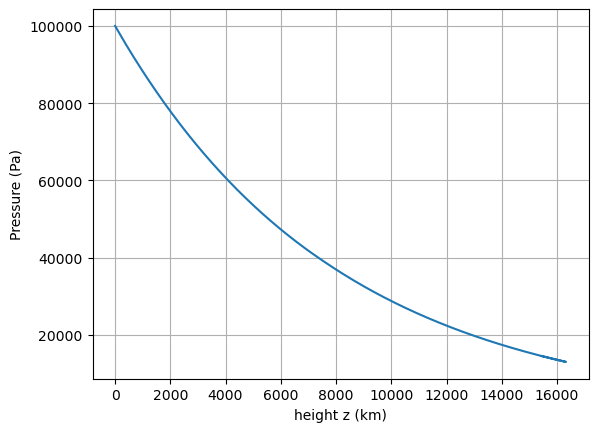

In [24]:
plt.figure()
plt.plot(Z, pressures)
plt.xlabel('height z (km)')
plt.ylabel('Pressure (Pa)')
#plt.title(f'Pressure that an air parcel is subjected to depending on height')
plt.grid(True)
plt.show()

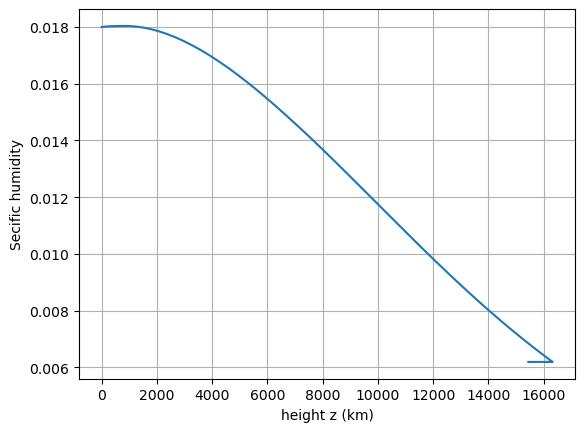

In [25]:
plt.figure()
plt.plot(Z, qs)
plt.xlabel('height z (km)')
plt.ylabel('Secific humidity')
#plt.title(f'Specific humidity of an air parcel depending on height')
plt.grid(True)
plt.show()

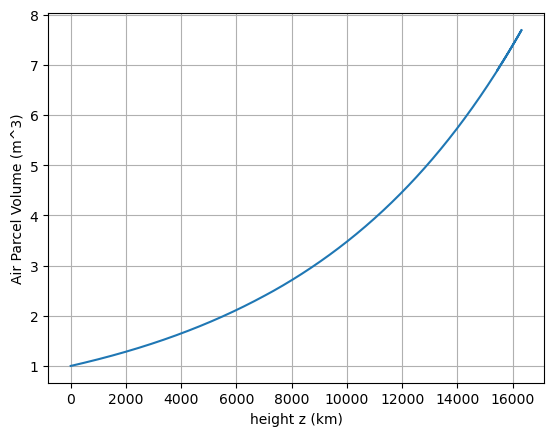

In [26]:
plt.figure()
plt.plot(Z, v_p_list)
plt.xlabel('height z (km)')
plt.ylabel('Air Parcel Volume (m^3)')
#plt.title(f'Specific humidity of an air parcel depending on height')
plt.grid(True)
plt.show()